# Getting started

This is a guide on how to run calibrate_manual.py, a script which generates plots for 9 different calibration targets using an FPsim run. The plots show the discrepancies between the model and the country comparison data and can be used for calibration by continually modifying the free parameters. The script can be run for any context with the modification of a few parameters at the top of the file. This guide walks through each portion of the calibrate_manual script (which is located in 'fpsim/fpsim/locations') as well as what setup is required in order to run it. The script uses Senegal as an example, though it can be used for calibration for any context.

To run, first install fpsim and its dependencies by typing 'pip install fpsim'. 

In [1]:
pip install fpsim

Note: you may need to restart the kernel to use updated packages.


# Setting up the data

In order to run calibrate_manual successfully, we need to ensure that the fpsim/locations directory contains both a directory for the country being calibrated (i.e. 'fpsim/locations/kenya') as well as a corresponding location file (i.e. 'kenya.py').

Next, the country data must be stored in the country directory mentioned above and with the following naming conventions:

    {country}_skyscrapers.csv' # Age-parity distribution file
    use_{country}.csv'         # Dichotomous contraceptive method use
    birth_spacing_dhs.csv'     # Birth-to-birth interval data
    afb.table.csv'             # Ages at first birth in DHS for women age 25-50
    {country}_cpr.csv'         # Contraceptive prevalence rate data; from UN Data Portal
    {country}_asfr.csv'        # Age-specific data fertility rate data
    mix_{country}.csv'         # Contraceptive method mix
    {country}_tfr.csv'         # Total fertility rate data 
    {country}_popsize.csv'     # Population by year

Ensure that the data in the aforementioned files is formatted in the same manner as the kenya data files,
which were used as a standard in writing this script.

### Examples are provided below:

kenya_skyscrapers.csv: (shows parity by each 5-year age bucket (up to age 49) for each dataset)

<img align="left" src="./data_examples/kenya_skyscrapers.png" alt="Alternative text"/>

use_kenya.csv: (shows dichotomous use/non-use contraceptive data)

<img align="left" src="./data_examples/use_kenya.png" alt="Alternative text"/>

birth_spacing_dhs.csv: (shows birth-to-birth interval data for both urban and rural areas with spacing months between 8 and 298)

<img align="left" src="./data_examples/birth_spacing_dhs.png" alt="Alternative text"/>

afb.table.csv: (Ages at first birth in DHS for women age 25-50)
    
<img align="left" src="./data_examples/afb.table.png" alt="Alternative text"/>

kenya_cpr.csv: (shows cpr data from 1970 thru 2030; from UN Data Portal)

<img align="left" src="./data_examples/kenya_cpr.png" alt="Alternative text"/>

kenya_asfr.csv: (shows asfr data aggregated in 5-year buckets (10-14 thru 50-54) from 1950 thru the most recent data)

<img align="left" src="./data_examples/kenya_asfr.png" alt="Alternative text"/>

mix_kenya.csv: (shows method mix by percentages; maintain the method indices for creating a file for a new country)

<img align="left" src="./data_examples/mix_kenya.png" alt="Alternative text"/>

kenya_tfr.csv: (tfr data from 1960 thru the most recent data)
    
<img align="left" src="./data_examples/kenya_tfr.png" alt="Alternative text"/>

kenya_popsize.csv: (shows country population from 1960 thru the most recent data)
    
<img align="left" src="./data_examples/kenya_popsize.png" alt="Alternative text"/>

# Running the Script

Once the steps above are completed, the script calibrate_manual can be run from the 'fpsim/locations/' directory. This tutorial will walk through each part of the script in the sections below.

### Imports
First, there are several packages we need to import:

In [2]:
import os
import numpy as np
import pandas as pd
import sciris as sc
import fpsim as fp
import pylab as pl
import seaborn as sns

### User Variables

The first section of the file's global variables should be set and/or evaluated by the user to configure the script for the specific context in mind.

To change the context/country being calibrated, change the 'country' parameter to the new location (must be a string). 

The plotting options (labeled 'do_plot_{target}') and option to save the figures/plots are all set to True by default, but these may be modified as desired. 

Lastly, the skyscrapers_dataset is the dataset contained in the skyscrapers .csv file to which the model data will be compared. This is set to 'PMA 2022' by default, but it can be set to a different dataset if needed/if the skyscrapers file does not contain PMA 2022 data. 

In [3]:
####################################################
# GLOBAL VARIABLES: USER MUST SET

# Name of the country being calibrated. To note that this should match the name of the country data folder
country = 'senegal'

# Set options for plotting
do_plot_sim = True
do_plot_asfr = True
do_plot_methods = True
do_plot_skyscrapers = True
do_plot_cpr = True
do_plot_tfr = True
do_plot_pop_growth = True
do_plot_birth_space_afb = True

# Set option to save figures
do_save = 1

# Dataset contained in the skyscrapers csv file to which the model data will be compared (i.e. 'PMA 2022',
# 'DHS 2014', etc). If this is set to a dataset not included in the {country}_skyscrapers.csv file, you will receive
# an error when running the script.
skyscrapers_dataset = 'DHS 2017'

####################################################

### Creating Figs Directory & Importing Country Data

This section of code does two things:
1) If the user has opted to store the calibration target plots (do_save set to 1) AND if a 'figs' directory does not already exist in the country directory (i.e. 'fpsim/locations/kenya/figs'), a 'figs' directory is then created for storing the plots. 

2) The country data is imported based on standardized paths (see the 'Setting Up the Data' section above). 

In [4]:
if do_save == 1 and os.path.exists(f'./{country}/figs') == False:
    os.mkdir(f'./{country}/figs')
    
# Import country data files to compare
skyscrapers = pd.read_csv(f'./{country}/{country}_skyscrapers.csv') # Age-parity distribution file
use = pd.read_csv(f'./{country}/use_{country}.csv') #Dichotomous contraceptive method use
data_spaces = pd.read_csv(f'./{country}/birth_spacing_dhs.csv')  # Birth-to-birth interval data
data_afb = pd.read_csv(f'./{country}/afb.table.csv')  # Ages at first birth in DHS for women age 25-50
data_cpr = pd.read_csv(f'./{country}/{country}_cpr.csv')  # From UN Data Portal
data_asfr = pd.read_csv(f'./{country}/{country}_asfr.csv')
data_methods = pd.read_csv(f'./{country}/mix_{country}.csv')
data_tfr = pd.read_csv(f'./{country}/{country}_tfr.csv')
data_popsize = pd.read_csv(f'./{country}/{country}_popsize.csv')

### Setting Additional Global Variables

These are additional global variables that are set as assumptions for the model (i.e. age_bin_map, min/max age, first birth age, bin size, etc). 

In [5]:
# Set up global variables
age_bin_map = {
        '10-14': [10, 15],
        '15-19': [15, 20],
        '20-24': [20, 25],
        '25-29': [25, 30],
        '30-34': [30, 35],
        '35-39': [35, 40],
        '40-44': [40, 45],
        '45-49': [45, 50]
}

min_age = 15
max_age = 50
first_birth_age = 25  # age to start assessing first birth age in model
bin_size = 5
mpy = 12  # months per year

### Simulation Free Parameters

Here are the free parameters that can be modified, including: n_agents, end_year, fecundity, exposure_factor, high_parity, postpartum sexual activity correction/birth spacing preference, etc.

In [6]:
# Set up sim for country
pars = fp.pars(location=country)
pars['n_agents'] = 100_000 # Small population size
pars['end_year'] = 2020 # 1961 - 2020 is the normal date range

# Free parameters for calibration
pars['fecundity_var_low'] = 0.95
pars['fecundity_var_high'] = 1.05
pars['exposure_factor'] = 1
pars['high_parity'] = 1
pars['high_parity_nonuse'] = 1

# Last free parameter, postpartum sexual activity correction or 'birth spacing preferece'
# Set all to 1 to reset
spacing_pars = {'space0_6': 1, 'space18_24': 1, 'space27_36': 1, 'space9_15': 1}  # output from 'optimize-space-prefs-{country}.py'
pars['spacing_pref']['preference'][:3] = spacing_pars['space0_6']
pars['spacing_pref']['preference'][3:6] = spacing_pars['space9_15']
pars['spacing_pref']['preference'][6:9] = spacing_pars['space18_24']
#pars['spacing_pref']['preference'][9:] = spacing_pars['space27_36'] # Removing this bin for Kenya as it doesn't extend out

# Only other free parameters are age-based exposure and parity-based exposure, can adjust manually in {country}.py

### Running the Sim

Here we set the sim parameters we just defined & run the sim.

In [7]:
sim = fp.Sim(pars=pars)
sim.run()

  Running 1960 of 2020 ( 0/721) (0.58 s)  ———————————————————— 0%
  Running 1961 of 2020 (12/721) (1.27 s)  ———————————————————— 2%
  Running 1962 of 2020 (24/721) (2.07 s)  ———————————————————— 3%
  Running 1963 of 2020 (36/721) (2.88 s)  •——————————————————— 5%
  Running 1964 of 2020 (48/721) (3.57 s)  •——————————————————— 7%
  Running 1965 of 2020 (60/721) (4.34 s)  •——————————————————— 8%
  Running 1966 of 2020 (72/721) (5.28 s)  ••—————————————————— 10%
  Running 1967 of 2020 (84/721) (6.10 s)  ••—————————————————— 12%
  Running 1968 of 2020 (96/721) (7.03 s)  ••—————————————————— 13%
  Running 1969 of 2020 (108/721) (8.19 s)  •••————————————————— 15%
  Running 1970 of 2020 (120/721) (9.47 s)  •••————————————————— 17%
  Running 1971 of 2020 (132/721) (10.50 s)  •••————————————————— 18%
  Running 1972 of 2020 (144/721) (11.54 s)  ••••———————————————— 20%
  Running 1973 of 2020 (156/721) (12.86 s)  ••••———————————————— 22%
  Running 1974 of 2020 (168/721) (14.14 s)  ••••————————————

Sim(<no label>; n=100000; 1960-2020; results: b=877535 ☠=129256 pop=787858)

### Post-Sim Processing

Once the sim run completes, we plot the sim results, save the results and people, and set up dictionaries to compare the model vs data.

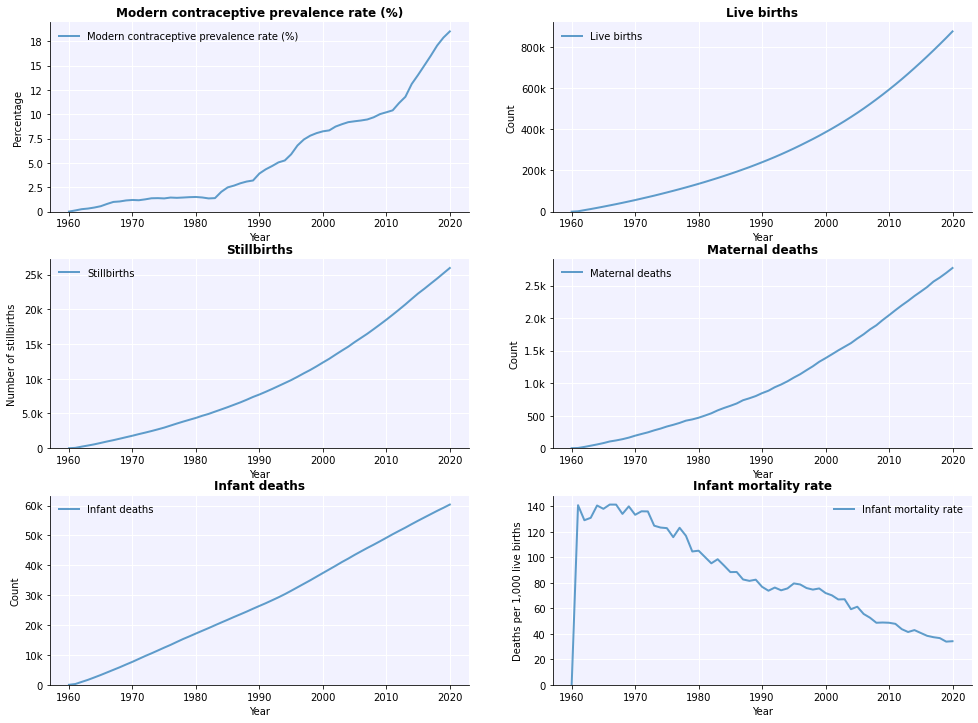

In [8]:
# Plot results from sim run
if do_plot_sim:
    sim.plot()

# Save results
res = sim.results

# Save people from sim
ppl = sim.people

# Set up dictionaries to compare from model vs data
data_dict = {}
model_dict = {} # For comparison from model to data

### Pop Growth Rate Function

This function is used in plotting the Population Growth Rate in the model vs the country data. It calculates the growth rate as a time series to aid in this comparison.

In [9]:
def pop_growth_rate(years, population):
        '''
        Calculates growth rate as a time series to help compare model to data
        '''
        growth_rate = np.zeros(len(years) - 1)

        for i in range(len(years)):
                if population[i] == population[-1]:
                        break
                growth_rate[i] = ((population[i + 1] - population[i]) / population[i]) * 100

        return growth_rate

### Age-Specific Fertility Rate Plot

This code is executed if the 'do_plot_asfr' is set to true. It generates a plot for the age-specific fertility rate between the model and the data.

ASFR (annual) for age bin 10-14 in the last year of the sim: 1.951426860134861
ASFR (annual) for age bin 15-19 in the last year of the sim: 97.38286495017785
ASFR (annual) for age bin 20-24 in the last year of the sim: 238.4928657232428
ASFR (annual) for age bin 25-29 in the last year of the sim: 275.1281598020152
ASFR (annual) for age bin 30-34 in the last year of the sim: 251.4831054939386
ASFR (annual) for age bin 35-39 in the last year of the sim: 187.64519535374868
ASFR (annual) for age bin 40-44 in the last year of the sim: 83.23632130384168
ASFR (annual) for age bin 45-49 in the last year of the sim: 10.172387016617487


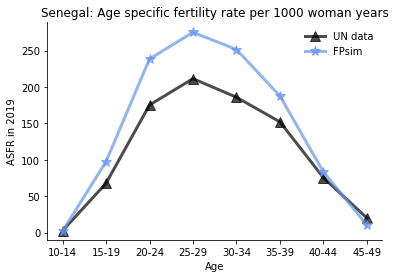

In [14]:
# Start series of options for plotting data to model comaprisons
if do_plot_asfr:
        '''
        Plot age-specific fertility rate between model and data
        '''
        # Print ASFR form model in output
        for key in age_bin_map.keys():
            print(f'ASFR (annual) for age bin {key} in the last year of the sim: {res["asfr"][key][-1]}')

        x = [1, 2, 3, 4, 5, 6, 7, 8]

        # Load data
        year = data_asfr[data_asfr['year'] == pars['end_year']]
        if '50-54' in year.columns:
                year = year.drop(['50-54'], axis=1)
        asfr_data = year.drop(['year'], axis=1).values.tolist()[0]
        
        x_labels = []
        asfr_model = []

        # Extract from model
        for key in age_bin_map.keys():
                x_labels.append(key)
                asfr_model.append(res['asfr'][key][-1])

        # Plot
        fig, ax = pl.subplots()
        kw = dict(lw=3, alpha=0.7, markersize=10)
        ax.plot(x, asfr_data, marker='^', color='black', label="UN data", **kw)
        ax.plot(x, asfr_model, marker='*', color='cornflowerblue', label="FPsim", **kw)
        pl.xticks(x, x_labels)
        pl.ylim(bottom=-10)
        ax.set_title(f'{country.capitalize()}: Age specific fertility rate per 1000 woman years')
        ax.set_xlabel('Age')
        ax.set_ylabel('ASFR in 2019')
        ax.legend(frameon=False)
        sc.boxoff()

        if do_save:
            pl.savefig(f'{country}/figs/asfr.png')

        pl.show()

### Contraceptive Method Plots

This code is executed if the 'do_plot_methods' is set to true. It generates two plots: contraceptive method mix (showing model vs the country data) and one showing dichotomous method use/non-use (model vs country data). 

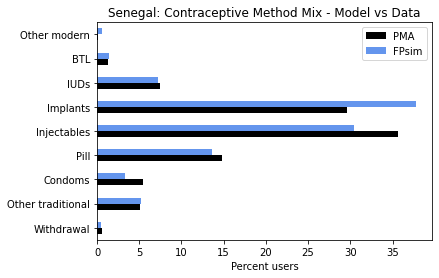

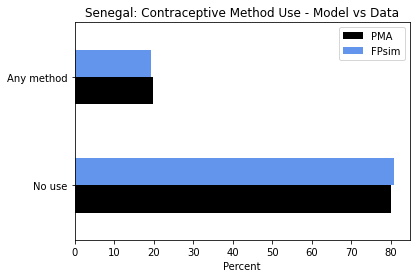

In [15]:
if do_plot_methods:
        '''
        Plots both dichotomous method use and non-use and contraceptive mix
        '''

        # Pull method definitions from parameters file
        # Method map; this remains constant across locations. True indicates modern method,
        # and False indicates traditional method
        methods_map_model = {  # Index, modern, efficacy
        'None': [0, False],
        'Withdrawal': [1, False],
        'Other traditional': [2, False],
        # 1/2 periodic abstinence, 1/2 other traditional approx.  Using rate from periodic abstinence
        'Condoms': [3, True],
        'Pill': [4, True],
        'Injectables': [5, True],
        'Implants': [6, True],
        'IUDs': [7, True],
        'BTL': [8, True],
        'Other modern': [9, True],
        }

        # Setup
        model_labels_all = list(methods_map_model.keys())
        model_labels_methods = sc.dcp(model_labels_all)
        model_labels_methods = model_labels_methods[1:]

        model_method_counts = sc.odict().make(keys=model_labels_all, vals=0.0)

        # Extract from model
        for i in range(len(ppl)):
                if ppl.alive[i] and not ppl.sex[i] and ppl.age[i] >= min_age and ppl.age[i] < max_age:
                        model_method_counts[ppl.method[i]] += 1

        model_method_counts[:] /= model_method_counts[:].sum()


        # Method mix from data - country PMA data (mix_{country}.csv)
        data_methods_mix = {
                'Withdrawal': data_methods.loc[data_methods['method'] == 'withdrawal', 'perc'].iloc[0],
                'Other traditional': data_methods.loc[data_methods['method'] == 'other traditional', 'perc'].iloc[0],
                'Condoms': data_methods.loc[data_methods['method'] == 'condoms', 'perc'].iloc[0],
                'Pill': data_methods.loc[data_methods['method'] == 'pill', 'perc'].iloc[0],
                'Injectables': data_methods.loc[data_methods['method'] == 'injectables', 'perc'].iloc[0],
                'Implants': data_methods.loc[data_methods['method'] == 'implant', 'perc'].iloc[0],
                'IUDs': data_methods.loc[data_methods['method'] == 'IUD', 'perc'].iloc[0],
                'BTL': data_methods.loc[data_methods['method'] == 'BTL/vasectomy', 'perc'].iloc[0],
                'Other modern': data_methods.loc[data_methods['method'] == 'other modern', 'perc'].iloc[0]
        }

        # Method use from data - country PMA data (use_{country}.csv)
        no_use = use.loc[0, 'perc']
        any_method = use.loc[1, 'perc']
        data_methods_use = {
                'No use': no_use,
                'Any method': any_method
        }

        # Plot bar charts of method mix and use among users

        # Calculate users vs non-users in model
        model_methods_mix = sc.dcp(model_method_counts)
        model_use = [model_methods_mix['None'], model_methods_mix[1:].sum()]
        model_use_percent = [i * 100 for i in model_use]

        # Calculate mix within users in model
        model_methods_mix['None'] = 0.0
        model_users_sum = model_methods_mix[:].sum()
        model_methods_mix[:] /= model_users_sum
        mix_model = model_methods_mix.values()[1:]
        mix_percent_model = [i * 100 for i in mix_model]

        # Set method use and mix from data
        mix_percent_data = list(data_methods_mix.values())
        data_use_percent = list(data_methods_use.values())

        # Set up plotting
        use_labels = list(data_methods_use.keys())
        df_mix = pd.DataFrame({'PMA': mix_percent_data, 'FPsim': mix_percent_model}, index=model_labels_methods)
        df_use = pd.DataFrame({'PMA': data_use_percent, 'FPsim': model_use_percent}, index=use_labels)

        # Plot mix
        ax = df_mix.plot.barh(color={'PMA':'black', 'FPsim':'cornflowerblue'})
        ax.set_xlabel('Percent users')
        ax.set_title(f'{country.capitalize()}: Contraceptive Method Mix - Model vs Data')
        if do_save:
                pl.savefig(f"{country}/figs/method_mix.png", bbox_inches='tight', dpi=100)

        # Plot use
        ax = df_use.plot.barh(color={'PMA':'black', 'FPsim':'cornflowerblue'})
        ax.set_xlabel('Percent')
        ax.set_title(f'{country.capitalize()}: Contraceptive Method Use - Model vs Data')
        if do_save:
                pl.savefig(f"{country}/figs/method_use.png", bbox_inches='tight', dpi=100)

### Age-Parity Distribution Plots

This code is executed if the 'do_plot_skyscrapers' is set to true. It generates three plots: age-parity distribution of the model, age-parity distribution of the country data, and age-parity distribution of the the data minus the model. 

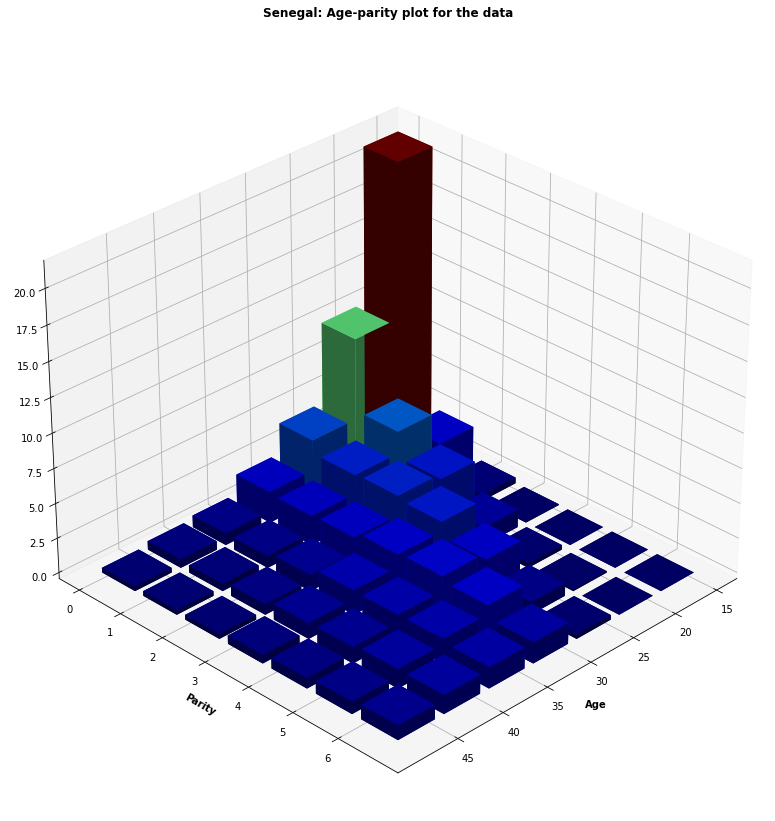

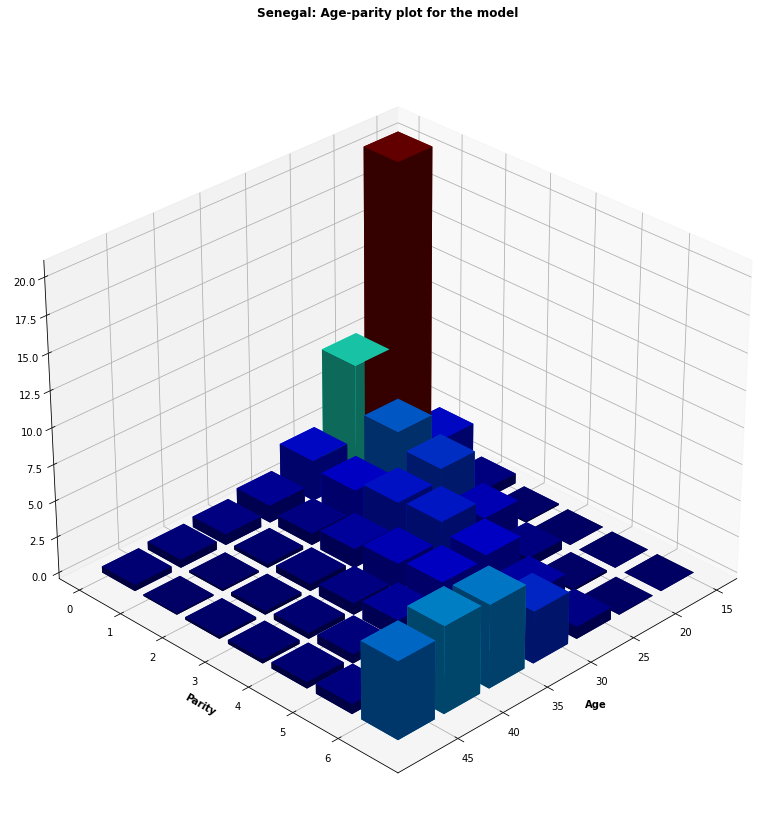

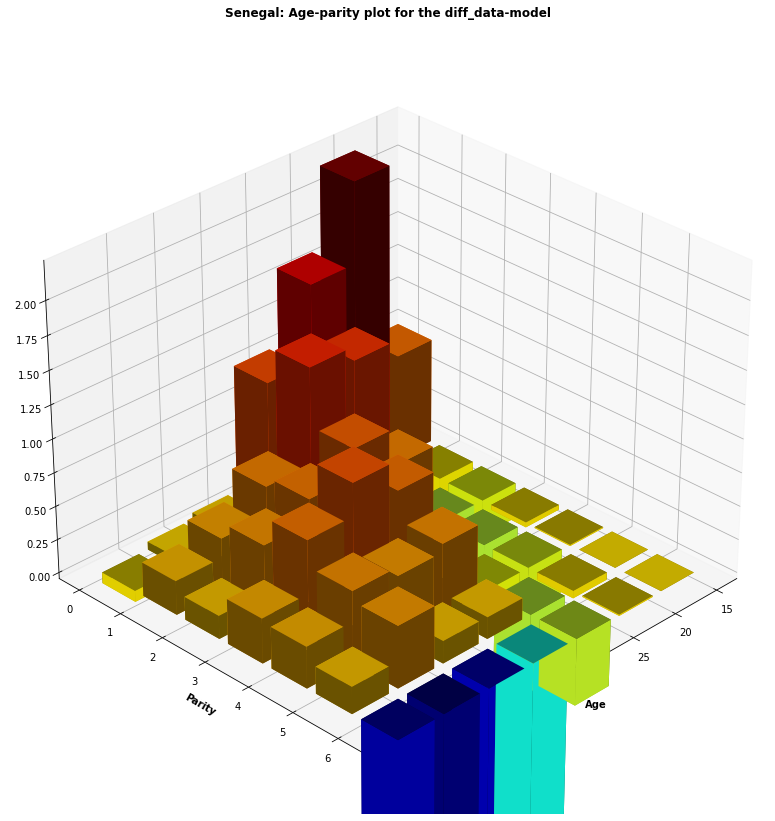

In [16]:
if do_plot_skyscrapers:
        '''
        Plot an age-parity distribution for model vs data
        '''

        # Set up
        age_keys = list(age_bin_map.keys())[1:]
        age_bins = pl.arange(min_age, max_age, bin_size)
        parity_bins = pl.arange(0, 7) # Plot up to parity 6
        n_age = len(age_bins)
        n_parity = len(parity_bins)
        x_age = pl.arange(n_age)
        x_parity = pl.arange(n_parity)  # Should be the same

        # Load data
        data_parity_bins = pl.arange(0,7)
        sky_raw_data = skyscrapers[skyscrapers['parity'] < 7]  # Only analyzing rows with parity <7
        sky_raw_data = sky_raw_data[sky_raw_data['dataset'] == skyscrapers_dataset]

        sky_parity = sky_raw_data['parity'].to_numpy()
        sky_props = sky_raw_data['percentage'].to_numpy()


        sky_arr = sc.odict()

        sky_arr['Data'] = pl.zeros((len(age_keys), len(parity_bins)))

        proportion = 0
        age_name = ''
        for age, row in sky_raw_data.iterrows():
                if row.age in age_keys:
                        age_ind = age_keys.index(row.age)
                        sky_arr['Data'][age_ind, row.parity] = row.percentage


        # Extract from model
        sky_arr['Model'] = pl.zeros((len(age_bins), len(parity_bins)))
        for i in range(len(ppl)):
                if ppl.alive[i] and not ppl.sex[i] and ppl.age[i] >= min_age and ppl.age[i] < max_age:
                        age_bin = sc.findinds(age_bins <= ppl.age[i])[-1]
                        parity_bin = sc.findinds(parity_bins <= ppl.parity[i])[-1]
                        sky_arr['Model'][age_bin, parity_bin] += 1


        # Normalize
        for key in ['Data', 'Model']:
                sky_arr[key] /= sky_arr[key].sum() / 100

        # Find diff to help visualize in plotting
        sky_arr['Diff_data-model'] = sky_arr['Data']-sky_arr['Model']

        # Plot skyscrapers
        for key in ['Data', 'Model', 'Diff_data-model']:
                fig = pl.figure(figsize=(20, 14))

                sc.bar3d(fig=fig, data=sky_arr[key], cmap='jet')
                pl.xlabel('Age', fontweight='bold')
                pl.ylabel('Parity', fontweight='bold')
                pl.title(f'{country.capitalize()}: Age-parity plot for the {key.lower()}\n\n', fontweight='bold')
                pl.gca().set_xticks(pl.arange(n_age))
                pl.gca().set_yticks(pl.arange(n_parity))
                pl.gca().set_xticklabels(age_bins)
                pl.gca().set_yticklabels(parity_bins)
                pl.gca().view_init(30, 45)
                pl.draw()


                if do_save:
                        pl.savefig(f'{country}/figs/skyscrapers_' + str(key.lower()) + '.png')

                pl.show()

### CPR Plot

This code is executed if the 'do_plot_cpr' is set to true. It generates a plot showing the CPR for both the model and country data.

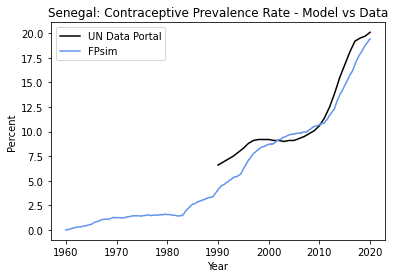

In [17]:
if do_plot_cpr:

        '''
        Plot contraceptive prevalence rate for model vs data
        '''
        # Import data
        data_cpr = data_cpr[data_cpr['year'] <= pars['end_year']] # Restrict years to plot

        # Plot
        pl.plot(data_cpr['year'], data_cpr['cpr'], label='UN Data Portal', color='black')
        pl.plot(res['t'], res['cpr']*100, label='FPsim', color='cornflowerblue')
        pl.xlabel('Year')
        pl.ylabel('Percent')
        pl.title(f'{country.capitalize()}: Contraceptive Prevalence Rate - Model vs Data')
        pl.legend()

        if do_save:
            pl.savefig(f'{country}/figs/cpr_over_sim.png')

        pl.show()

### Total Fertility Rate Plot

This code is executed if the 'do_plot_tfr' is set to true. It generates a plot showing the TFR for both the model and country data.

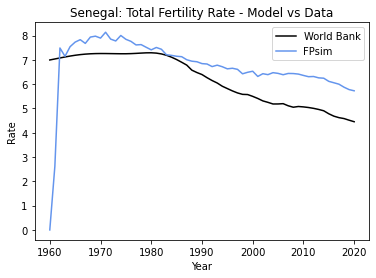

In [18]:
if do_plot_tfr:
        '''
        Plot total fertility rate for model vs data
        '''

        # Import data
        #data_tfr = pd.read_csv(f'{country}_tfr.csv')

        # Plot
        pl.plot(data_tfr['year'], data_tfr['tfr'], label='World Bank', color='black')
        pl.plot(res['tfr_years'], res['tfr_rates'], label='FPsim', color='cornflowerblue')
        pl.xlabel('Year')
        pl.ylabel('Rate')
        pl.title(f'{country.capitalize()}: Total Fertility Rate - Model vs Data')
        pl.legend()

        if do_save:
                pl.savefig(f'{country}/figs/tfr_over_sim.png')

        pl.show()

### Population Growth Plot

This code is executed if the 'do_plot_pop_growth' is set to true. It generates a plot showing the population growth rate for the model vs country data.

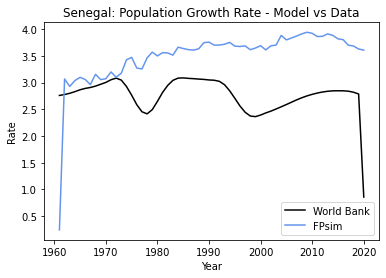

In [19]:
if do_plot_pop_growth:
        '''
        Plot annual population growth rate for model vs data
        '''

        # Import data
        data_popsize = data_popsize[data_popsize['year'] <= pars['end_year']]  # Restrict years to plot

        data_pop_years = data_popsize['year'].to_numpy()
        data_population = data_popsize['population'].to_numpy()

        # Extract from model
        model_growth_rate = pop_growth_rate(res['tfr_years'], res['pop_size'])

        data_growth_rate = pop_growth_rate(data_pop_years, data_population)

        # Plot
        pl.plot(data_pop_years[1:], data_growth_rate, label='World Bank', color='black')
        pl.plot(res['tfr_years'][1:], model_growth_rate, label='FPsim', color='cornflowerblue')
        pl.xlabel('Year')
        pl.ylabel('Rate')
        pl.title(f'{country.capitalize()}: Population Growth Rate - Model vs Data')
        pl.legend()

        if do_save:
            pl.savefig(f'{country}/figs//popgrowth_over_sim.png')

        pl.show()

### Birth spacing & Age-at-first-birth Plots

This code is executed if the param 'do_plot_birth_space_afb' is set to true. It generates two plots - the first shows the model vs country data for Age-at-First-Birth. The second shows the model vs data for Birth Spacing.

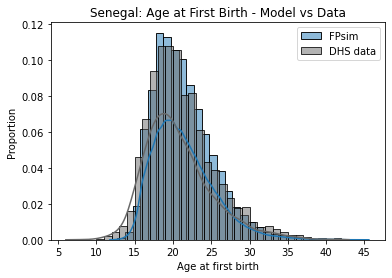

           Model       Data       Diff
0-12    4.214793   1.960161   2.254632
12-24  41.850660  24.536036  17.314624
24-48  40.096551  55.270767 -15.174216
>48    13.837997  18.233037  -4.395040


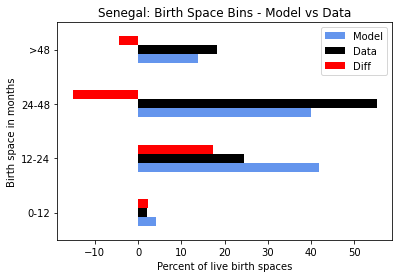

In [20]:
if do_plot_birth_space_afb:
        '''
        Plot birth space and age at first birth for model vs data
        '''

        # Set up
        spacing_bins = sc.odict({'0-12': 0, '12-24': 1, '24-48': 2, '>48': 4})  # Spacing bins in years
        model_age_first = []
        model_spacing = []
        model_spacing_counts = sc.odict().make(keys=spacing_bins.keys(), vals=0.0)
        data_spacing_counts = sc.odict().make(keys=spacing_bins.keys(), vals=0.0)


        # Extract age at first birth and birth spaces from model
        for i in range(len(ppl)):
                if ppl.alive[i] and not ppl.sex[i] and ppl.age[i] >= min_age and ppl.age[i] < max_age:
                        if len(ppl.dobs[i]) == 0:
                                model_age_first.append(float('inf'))
                        if len(ppl.dobs[i]) and ppl.age[i] >= first_birth_age:
                                model_age_first.append(ppl.dobs[i][0])
                        if len(ppl.dobs[i]) > 1:
                                for d in range(len(ppl.dobs[i]) - 1):
                                        space = ppl.dobs[i][d + 1] - ppl.dobs[i][d]
                                        ind = sc.findinds(space > spacing_bins[:])[-1]
                                        model_spacing_counts[ind] += 1
                                        model_spacing.append(space)

        # Normalize model birth space bin counts to percentages
        model_spacing_counts[:] /= model_spacing_counts[:].sum()
        model_spacing_counts[:] *= 100

        age_first_birth_model = pd.DataFrame(data=model_age_first)

        # Extract birth spaces and age at first birth from data
        for i, j in data_spaces.iterrows():
                space = j['space_mo'] / mpy
                ind = sc.findinds(space > spacing_bins[:])[-1]
                data_spacing_counts[ind] += j['Freq']

        age_first_birth_data = pd.DataFrame(data=data_afb)

        # Normalize dat birth space bin counts to percentages
        data_spacing_counts[:] /= data_spacing_counts[:].sum()
        data_spacing_counts[:] *= 100

        # Plot age at first birth (histogram with KDE)
        sns.histplot(data=age_first_birth_model, stat='proportion', kde=True, binwidth=1, color='cornflowerblue', label='FPsim')
        sns.histplot(x=age_first_birth_data['afb'], stat='proportion', kde=True, weights=age_first_birth_data['wt'], binwidth=1, color='dimgrey', label='DHS data')
        pl.xlabel('Age at first birth')
        pl.title(f'{country.capitalize()}: Age at First Birth - Model vs Data')
        pl.legend()

        if do_save:
            pl.savefig(f'{country}/figs/age_first_birth.png', bbox_inches='tight', dpi=100)

        pl.show()
        
        
        # Plot birth space bins with diff
        data_dict['spacing_bins'] = np.array(data_spacing_counts.values())
        model_dict['spacing_bins'] = np.array(model_spacing_counts.values())

        diff = model_dict['spacing_bins'] - data_dict['spacing_bins']

        res_bins = np.array([[model_dict['spacing_bins']], [data_dict['spacing_bins']], [diff]])

        bins_frame = pd.DataFrame(
                {'Model': model_dict['spacing_bins'], 'Data': data_dict['spacing_bins'], 'Diff': diff},
                index=spacing_bins.keys())

        print(bins_frame) # Print in output, remove if not needed

        ax = bins_frame.plot.barh(color={'Data': 'black', 'Model': 'cornflowerblue', 'Diff': 'red'})
        ax.set_xlabel('Percent of live birth spaces')
        ax.set_ylabel('Birth space in months')
        ax.set_title(f'{country.capitalize()}: Birth Space Bins - Model vs Data')

        if do_save:
                pl.savefig(f'{country}/figs/birth_space_bins_{country}.png', bbox_inches='tight', dpi=100)

        pl.show()

Thank you for taking the time to learn about this calibration script! If you'd like to run it on your own, just be sure to follow the setup instructions at the top of this notebook (i.e. setting the global variables properly, naming and structuring the country data files properly, etc) and then you may run the script 'fpsim/locations/calibrate_manual.py' in the fpsim repo. 